In [1]:
##  China rain decadal difference figure

## Take output from china_rain_diff, saved as chinarain_diff_pval_notaiwan_*, and produce
## plots showing changes between decades, only showing significant changes.

## End product: two figures named chinarain_diff_notaiwan_8007_5179.pdf and chinarain_diff_notaiwan_9407_8093.pdf

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import netCDF4 as nc
%matplotlib notebook
%load_ext autotime
from bootstrap import *
import numpy.ma as ma
from chr_matplotlib import remappedColorMap
import os
from shutil import copy

from jd_matplotlib_tools import add_double_calendar_axis, mark_time_periods

In [3]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin/"
ff = "Pchina_type_notaiwan.nc"
filename = ferretpath + ff
myf = nc.Dataset(filename, 'r')

time: 6.64 ms


In [4]:
P_total =  myf.variables['Pchina_total'][:]
P_band = myf.variables['Pchina_band'][:]
P_local = myf.variables['Pchina_local'][:]

time: 85.3 ms


In [5]:
#years of interest - start and end date, with index starting at 1 out of habit.
p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_total_diff = []
P_band_diff = []
P_local_diff = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_total_diff.append(np.mean(P_total[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local[:,:,p1_b-1:p1_e], axis=2))

time: 20 ms


In [6]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 6.23 ms


In [7]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

#one line! thank you python!
P_total_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff ]
P_band_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff ]
P_local_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff ]

time: 4.15 s


In [8]:
## LOAD COMPUTED P-VALUES ##

#which set of sim values are we trying to access?
pval_root = 'Data/chinarain_diff_pval_notaiwan_'
blklen = 2
niter = 2000

P_total_diff_pval = []
P_band_diff_pval = []
P_local_diff_pval = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    #LOAD P-VALUES FOR TOTAL RAINFALL
    raintype = 'total'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_total_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
    
    
    ##LOAD P-VALUES FOR BANDED RAINFALL
    raintype = 'band'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_band_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')
            
    ##LOAD P-VALUES FOR LOCAL RAINFALL
    raintype = 'local'
    yrs = str(p1_b+50) + str(p1_e+50) + '_' + str(p2_b+50) + str(p2_e+50) + '_'
    pval_filename = pval_root + yrs + raintype + '_' + str(blklen) + 'day_' \
        + str(niter) + 'iter.nc'
    
    if os.path.isfile(pval_filename):
        print(pval_filename + ' successfully found')
        myf = nc.Dataset(pval_filename, 'r')
        P_local_diff_pval.append(myf.variables['pval'][:])
        myf.close()
        
    else:
        print(pval_filename + ' does not exist')    
        
    #P_total_diff.append()
    #P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
    #P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \


Data/chinarain_diff_pval_notaiwan_5179_80107_total_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_5179_80107_band_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_5179_80107_local_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_total_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_band_2day_2000iter.nc successfully found
Data/chinarain_diff_pval_notaiwan_8093_94107_local_2day_2000iter.nc successfully found
time: 81.5 ms


In [9]:
## CREATE MASKED ARRAYS - only show values that are statistically significant
#create two masked arrays - one showing 95% confidence, one showing 99% confidence

##two separate for loops: first one creates masks, second one produces masked rainfall.
#reason for doing things this way is that masks can then be accessed independently at a later point in time.

#not super-pythonic method, but at least it makes it easy to understand.

mk_total = [] #storage format will be a LIST of 2-element tuples - each set of tuples is the 95% and 99% mask respectively
mk_band = []
mk_local = []

#set up 95th and 99th percentile masks for each type of rainfall
for P_total_diff, P_band_diff, P_local_diff, P_total_pval, P_band_pval, P_local_pval in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, P_total_diff_pval, P_band_diff_pval, P_local_diff_pval):
    
    mk_total_95 = abs(P_total_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_total_99 = abs(P_total_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_total.append([mk_total_95, mk_total_99])
    
    mk_band_95 = abs(P_band_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_band_99 = abs(P_band_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_band.append([mk_band_95, mk_band_99])
    
    mk_local_95 = abs(P_local_pval-.5) < .475 #95th percentile mask for rainfall changes
    mk_local_99 = abs(P_local_pval-.5) < .495 #99th percentile mask for rainfall changes
    mk_local.append([mk_local_95, mk_local_99])
    
#create masked arrays
P_total_diff_mask = []
P_band_diff_mask = []
P_local_diff_mask = []

#create masked arrays with significant rainfall changes only based on 95th percentile masks
for P_total_diff, P_band_diff, P_local_diff, mask_total, mask_band, mask_local in \
    zip(P_total_diff_smth, P_band_diff_smth, P_local_diff_smth, mk_total, mk_band, mk_local):
    
    P_total_diff_mask.append(ma.array(P_total_diff, mask = mask_total[0]))
    P_band_diff_mask.append(ma.array(P_band_diff, mask = mask_band[0]))
    P_local_diff_mask.append(ma.array(P_local_diff, mask = mask_local[0]))

time: 16.6 ms


In [10]:
## DEFINE TIME PERIODS OF INTEREST
time_periods = [[80.5,120.5],[120.5,160.5],[160.5,200.5],[200.5,273.5],[273.5,320.5]]

time: 729 µs


<IPython.core.display.Javascript object>


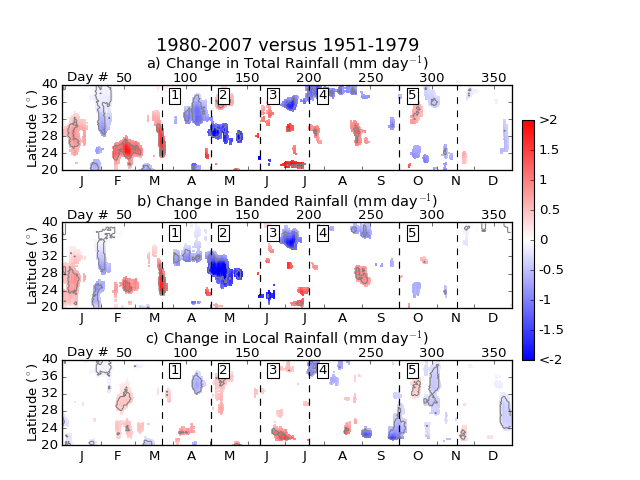

//anaconda/lib/python3.5/site-packages/matplotlib/text.py:2130: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...
time: 36.5 s


In [13]:
## CREATE FIGURE OF 1951-1979 v 1980-2007 changes

axlim = 2 #sets the maximum and minimum for colorbar.
mypalette = 'bwr'

## Set up axis and title for the entire figure
fig, ax = plt.subplots()
ax.set_title("1980-2007 versus 1951-1979", fontsize=16, y = 1.08)
ax.set_axis_off()

## Subplot a) - changes in TOTAL rainfall
ax1 = fig.add_subplot(3,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[0][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')


## Subplot b) - changes in BANDED rainfall
ax2 = fig.add_subplot(3,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[0][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')



## Subplot c) - changes in LOCAL rainfall
ax3 = fig.add_subplot(3,1,3)
plot3 = ax3.pcolormesh(P_local_diff_mask[0].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_local[0][1].T,1,colors = 'gray')
ax3.set_title("c) Change in Local Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')



## tighten up resulting plots
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.815, 0.25, 0.02, 0.5])
cbar = fig.colorbar(plot1, cax = cbar_ax, ticks=np.linspace(-axlim,axlim,9))
cbar.ax.set_yticklabels(['<-2',-1.5,-1,-.5,0,.5,1,1.5,'>2'])  # horizontal colorbar


## SAVE FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "chinarain_diff_notaiwan_8007_5179.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')

In [ ]:
## CREATE FIGURE OF 1980-1993 v 1994-2007 changes

axlim = 4 #sets the maximum and minimum for colorbar.

fig, ax = plt.subplots()
ax.set_title("1994-2007 versus 1980-1993", fontsize=16, y = 1.08)
mypalette = 'bwr'

ax.set_axis_off()


## Subplot a) - changes in TOTAL rainfall
ax1 = fig.add_subplot(3,1,1)
plot1 = ax1.pcolormesh(P_total_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_total[1][1].T,1,colors = 'gray')
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')



## Subplot b) - changes in BANDED rainfall
ax2 = fig.add_subplot(3,1,2)
plot2 = ax2.pcolormesh(P_band_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_band[1][1].T,1,colors = 'gray')
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')



## Subplot c) - changes in LOCAL rainfall
ax3 = fig.add_subplot(3,1,3)
plot3 = ax3.pcolormesh(P_local_diff_mask[1].T, cmap = mypalette, vmin = -axlim, vmax = axlim); 
plt.contour(mk_local[1][1].T,1,colors = 'gray')
ax3.set_title("c) Change in Local Rainfall (mm day$^{-1}$)", fontsize=13, y=1.12)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
plt.yticks(np.linspace(0,80,6),np.linspace(20,40,6).astype(int))

add_double_calendar_axis()
mark_time_periods(time_periods, numbers = 'yes')



#tighten up plot layout
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([.815, 0.25, 0.02, 0.5])
cbar = fig.colorbar(plot2, cax = cbar_ax, ticks=np.linspace(-axlim,axlim,9))
cbar.ax.set_yticklabels(['<-4',-3,-2,-1,0,1,2,3,'>4'])  # horizontal colorbar


## SAVE FIGURE TO MANUSCRIPT AND ANALYSIS DIRECTORIES
figure_name = "chinarain_diff_notaiwan_9407_8093.pdf"

savepath = "/Users/Siwen/Desktop/RDA/Figures/" + figure_name

if os.path.exists(savepath):
    print("Overwriting existing version of file in RDA manuscript directory...")
    os.remove(savepath)
    
plt.savefig(savepath)
    
copypath = "/Users/Siwen/RDA/Figures/" + figure_name
    
if os.path.exists(copypath):
    print("Overwriting existing version of file in RDA Python directory...")
    os.remove(copypath)
    
copy(savepath,copypath)

plt.savefig(savepath, bbox_inches='tight')

<IPython.core.display.Javascript object>

//anaconda/lib/python3.5/site-packages/matplotlib/text.py:2130: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


Overwriting existing version of file in RDA manuscript directory...
Overwriting existing version of file in RDA Python directory...
